<h1> TP Séparation de sources </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Génération de sources et d'un mélange

In [2]:
def generatesources(Nsources, Nsamples, choice):
    """ Generates sources with independent components (for ICA/BSS)

    Returned sources are normalized.

    Parameters
    ----------
    Nsources : int, number of sources
    Nsamples : int, number of samples
    choice : selected type of sources: 'bpsk', 'rand'

    Returns
    -------
    sources : ndarray Nsour x Nsamples
              realization of the sources
    """
    if choice == 'bpsk':
        sources = np.sign(np.random.randn(Nsources, Nsamples))
    elif choice == 'rand':
        sources = np.random.rand(Nsources, Nsamples) - 0.5

    # renormalize (unit variance)
    if Nsamples == 0:
        sources = np.empty((Nsources, 0))
    else:
        renormfactors = 1/np.sqrt((sources**2).sum(axis=1)/Nsamples)
        sources = sources*np.repeat(renormfactors[:, np.newaxis], Nsamples,
                                    axis=1)
    return sources

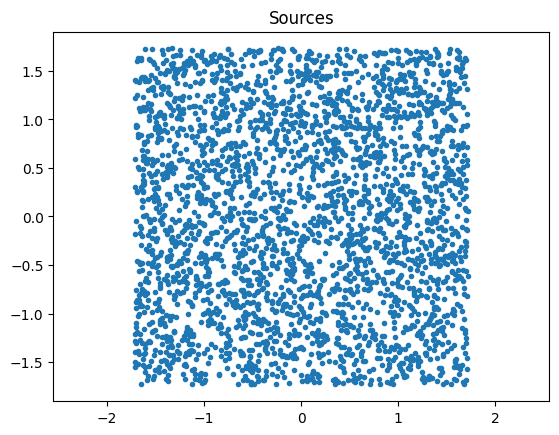

In [3]:
N, T = 2, 3000
S = generatesources(N, T, "rand")
fig, ax = plt.subplots()
ax.plot(S[0, :], S[1, :], linestyle="", marker=".")
_ = ax.axis("equal")
_ = ax.set_title("Sources")

In [4]:
def cum(X):
    """ Estimates 4th order cumulant 
    
    Parameters
    ----------
    X : array (N, T)
    
    Returns
    -------
    C : array (N, 1)
        Each component of C is an empirical estimate of corresponing row of X 
    """
    T = X.shape[1]
    M4 = (X**4).sum(axis=1)/T
    M2 = (X**2).sum(axis=1)/T
    C = M4 - 3*M2**2
    return C[:, np.newaxis]

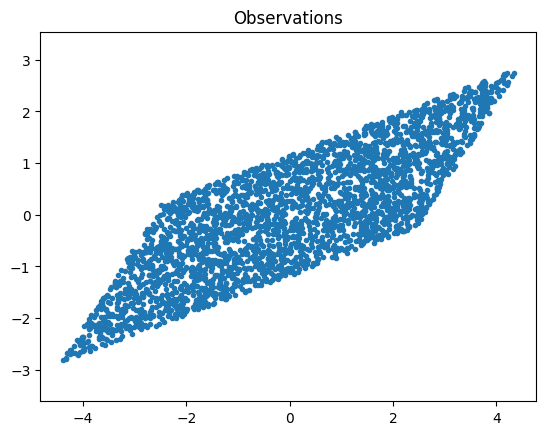

In [5]:
A = np.random.randn(N, N)
X = A@S
fig, ax = plt.subplots()
ax.plot(X[0, :], X[1, :], linestyle="", marker=".")
_ = ax.axis("equal")
_ = ax.set_title("Observations")

## Approche par blanchiment

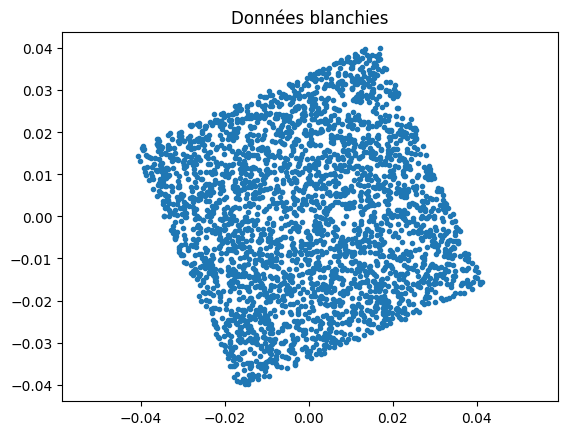

In [6]:
U, S, V = np.linalg.svd(X, full_matrices=False)  # np.allclose(U@np.diag(S)@V  - X, 0)
W = U@np.diag(1/S)
Z = W.T@X
fig, ax = plt.subplots()
ax.plot(Z[0, :], Z[1, :], linestyle="", marker=".")
_ = ax.axis("equal")
_ = ax.set_title("Données blanchies")

In [7]:
def rotation(theta):
    """ Returns 2x2 rotation matrix with angle theta
    """
    M = np.array([[np.cos(theta), np.sin(theta)], 
                  [-np.sin(theta), np.cos(theta)]])
    return M

def contraste1(Y):
    """ Valeur du contraste C1 du TP """
    return abs(cum(Y)).sum()

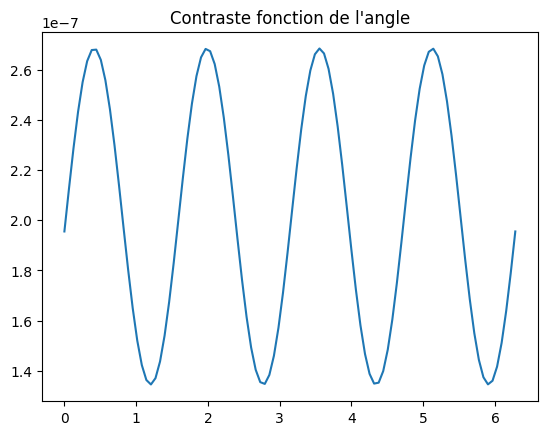

In [8]:
theta_valeurs = np.linspace(0, 2*np.pi, 100)
contraste1_valeurs = []
for theta in theta_valeurs:
    contraste1_valeurs.append(contraste1(rotation(theta)@Z))
fig, ax = plt.subplots()
_ = ax.plot(theta_valeurs, contraste1_valeurs)
_ = ax.set_title("Contraste fonction de l'angle")
    

## Approche par déflation

In [9]:
# fonctions pour evaluation du critère, gradient, facteur de renormalisation
def crit(b, X):
    """ Evaluates (Cum4{y}/E{y^2}^2)^2, where y=b.T x"""
    nsamples = X.shape[1]
    y = b.T@X
    M4 = (y**4).sum(axis=1)/nsamples
    M2 = (y**2).sum(axis=1)/nsamples
    return (M4/M2**2 - 3)**2
    
def grad(b, X):
    """ Evaluates gradient of(Cum4{y}/E{y^2}^2)^2, where y=b.T x"""
    nsamples = X.shape[1]
    y = b.T@X
    M4 = (y**4).sum(axis=1)/nsamples
    M2 = (y**2).sum(axis=1)/nsamples
    dM4 = 4*((y**3)*X).sum(axis=1)/nsamples
    dM2 = 2*(y*X).sum(axis=1)/nsamples
    dJ = 2*(M4/M2**2-3)*(dM4/M2**2 - 2*M4/M2**3*dM2)
    return dJ[:, np.newaxis]

def renorm(b, X):
    """ Evaluate renomalization factor sqrt(E{y^2}) where y=b.T x"""
    return np.sqrt(((b.T@X)**2).mean(axis=1))

# gradient projeté
def projgrad(X, mu=1e-3):
    """ Projected gradient algorithm for maximizing crit"""
    MAXITER = 1000
    b = np.ones((N, 1))
    b = b/renorm(b, X)
    crit_trace = [crit(b, X)]
    for i in range(MAXITER):
        b = b + mu*grad(b, X)
        b = b/renorm(b, X)
        crit_trace.append(crit(b, X))
    return b, crit_trace

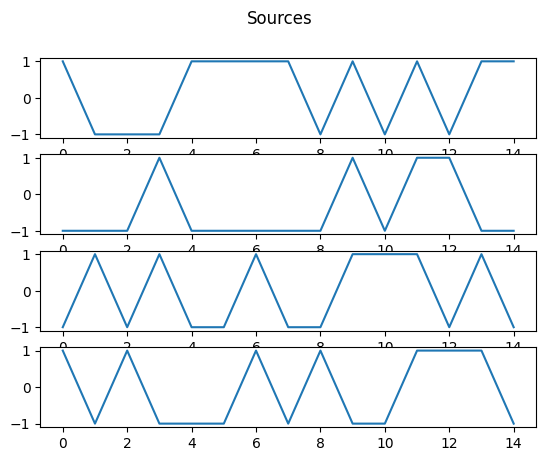

In [10]:
N, T = 4, 5000
S = generatesources(N, T, "bpsk")
fig, ax = plt.subplots(N, 1)
for i in range(N):
    ax[i].plot(S[i, 0:15])
_ = fig.suptitle("Sources")

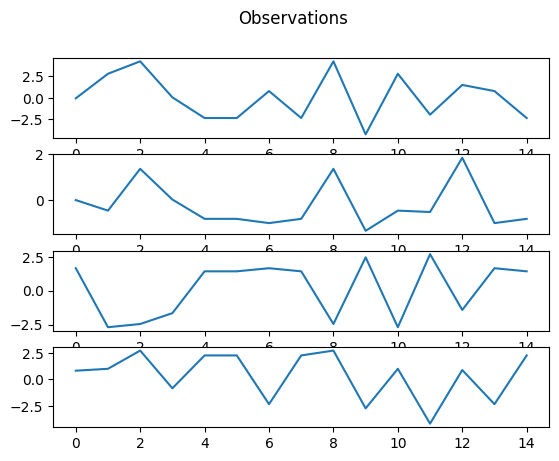

In [11]:
A = np.random.randn(N, N)
X = A@S
fig, ax = plt.subplots(N, 1)
for i in range(N):
    ax[i].plot(X[i, 0:15])
_ = fig.suptitle("Observations")

In [12]:
b, crit_trace = projgrad(X)

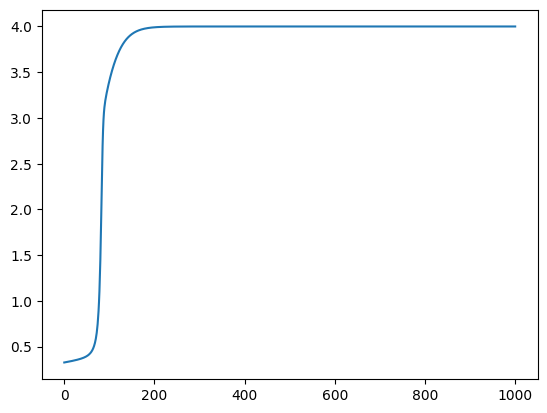

In [13]:
plt.plot(crit_trace)

In [14]:
b.T@A

array([[ 1.43437224e-10, -2.81997337e-10, -1.00000000e+00,
         4.04393180e-11]])

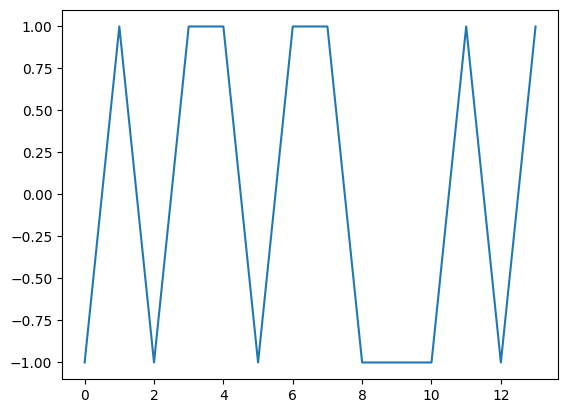

In [15]:
y = b.T@X
plt.plot(y[:, 1:15].T)